<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/content/drive/.shortcut-targets-by-id/1tHYgEz3lQF-LmtFPXRgMBDh4UN54qeAs/datas


###Load Dataset

In [2]:
path = path_root + 'mpie_30_shuffle/'

def loadDatasetFromCSV(_datafilename, _labelfilename, label_column):
  _train_feature_csv = pd.read_csv(path + _datafilename, dtype=np.float32, header=None) # image features of train data
  _train_feature_flatten = _train_feature_csv.values.flatten()
  _train_feature_reshape = np.reshape(_train_feature_flatten, (_train_feature_csv.shape[0], 32,-1))

  _train_label_csv = pd.read_csv(path + _labelfilename, dtype=np.float32, header=None) # labels of train data
  _train_label = _train_label_csv[label_column] # get label you want

  return _train_feature_reshape, _train_label

In [3]:
import pandas as pd
import numpy as np

# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', 0)
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', 0)

train_feature_reshape.shape, train_label.shape, validation_feature_reshape.shape, validation_label.shape

((18777, 32, 32), (18777,), (5086, 32, 32), (5086,))

In [4]:
import tensorflow as tf

def preprocessDataset(features_reshape, labels, batch_size=64, shuffle_buffer_size=100):
  _batch_size = batch_size
  _shuffle_buffer_size = shuffle_buffer_size

  _features = features_reshape
  _labels = labels
  _dataset_tensors = tf.data.Dataset.from_tensor_slices((_features, _labels))

  if _shuffle_buffer_size == None:
    _dataset_tensors = _dataset_tensors.batch(_batch_size)
  else :
    _dataset_tensors = _dataset_tensors.shuffle(_shuffle_buffer_size).batch(_batch_size)

  return _dataset_tensors

In [5]:
train_dataset = preprocessDataset(train_feature_reshape, train_label)

In [6]:
# train_dataset?

In [7]:
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

###Load Trained Model

In [8]:
import pickle
with open('results.pickle', 'rb') as f:
  results = pickle.load(f)
results   # model, history, execution_time, _params

[(<keras.engine.sequential.Sequential at 0x7ff1f864ad10>,
  169.9560625553131,
  {'_kernel_size': (3, 3),
   '_padding': 'same',
   '_pool_size': (2, 2),
   '_strides': (1, 1),
   'filters': 16}),
 (<keras.engine.sequential.Sequential at 0x7ff1f3e04b50>,
  134.39186811447144,
  {'_kernel_size': (3, 3),
   '_padding': 'valid',
   '_pool_size': (2, 2),
   '_strides': (1, 1),
   'filters': 16}),
 (<keras.engine.sequential.Sequential at 0x7ff1f3e344d0>,
  196.5999310016632,
  {'_kernel_size': (5, 5),
   '_padding': 'same',
   '_pool_size': (2, 2),
   '_strides': (1, 1),
   'filters': 16}),
 (<keras.engine.sequential.Sequential at 0x7ff1f3ab8e50>,
  36.18425917625427,
  {'_kernel_size': (3, 3),
   '_padding': 'same',
   '_pool_size': (2, 2),
   '_strides': (3, 3),
   'filters': 16}),
 (<keras.engine.sequential.Sequential at 0x7ff1f37e6ed0>,
  33.84725499153137,
  {'_kernel_size': (3, 3),
   '_padding': 'same',
   '_pool_size': (4, 4),
   '_strides': (3, 3),
   'filters': 16}),
 (<keras.engi

## show model

In [9]:
def drawModel(index, model, savefile=True):
  tf.keras.utils.plot_model(model, to_file=f'model_{index}.png', show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, ) #layer_range=?, 

model = results[0][0]
# drawModel(None, model)
print(len(model.layers), model.layers, )

8 [<keras.layers.convolutional.Conv2D object at 0x7ff1f877ae90>, <keras.layers.core.activation.Activation object at 0x7ff1f41cae90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff1f41005d0>, <keras.layers.pooling.MaxPooling2D object at 0x7ff1f40a5590>, <keras.layers.core.flatten.Flatten object at 0x7ff1f40a8250>, <keras.layers.core.dense.Dense object at 0x7ff1f40a8c50>, <keras.layers.core.dropout.Dropout object at 0x7ff1f40ad890>, <keras.layers.core.dense.Dense object at 0x7ff1f40b3310>]


###drawing history model

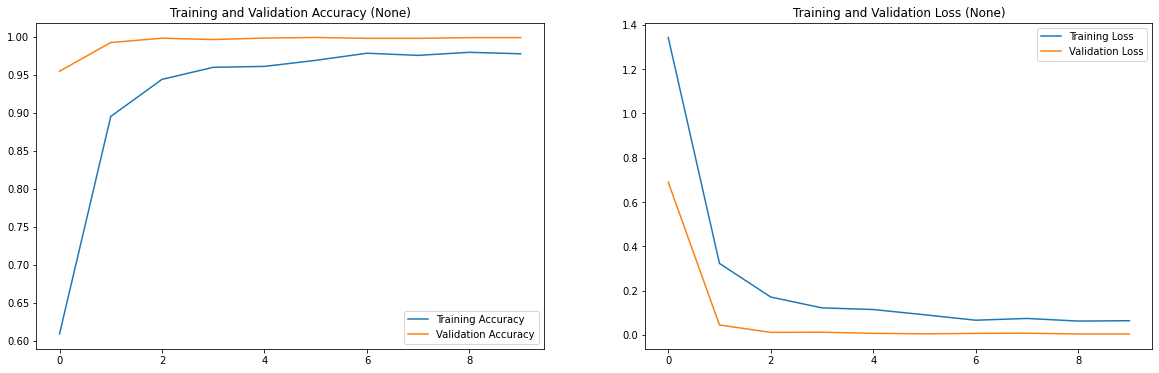

In [10]:
import matplotlib.pyplot as plt

def drawModelHistory(index, history, training_time, filesave=True):
  _epochs = history.params['epochs']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(_epochs)
  # acc, list(epochs_range)

  plt.figure(figsize=(20, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title(f'Training and Validation Accuracy ({index})')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title(f'Training and Validation Loss ({index})')
  plt.savefig(f'history_{index}.png', bbox_inches='tight')
  plt.show()

history = results[0][1]
drawModelHistory(None, history, None)

##make list from anothers params

In [11]:
training_time = results[0][2]
params = results[0][3]

In [12]:
history.history.keys(), history.params.keys(), training_time, params.keys()

(dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']),
 dict_keys(['verbose', 'epochs', 'steps']),
 169.9560625553131,
 dict_keys(['filters', '_padding', '_kernel_size', '_strides', '_pool_size']))

In [13]:
list(history.history.values())[0], type(history.history.values()), 

([1.3433936834335327,
  0.3225732743740082,
  0.17080780863761902,
  0.12169625610113144,
  0.11427143961191177,
  0.09065400809049606,
  0.06600591540336609,
  0.07396136969327927,
  0.06212208792567253,
  0.06376597285270691],
 dict_values)

In [14]:
import numpy as np

history_values = np.array(list(history.history.values()))
history_values.shape, history_values[:,-1], list(history_values[:,-1])


((4, 10),
 array([0.06376597, 0.97752571, 0.00385777, 0.9988203 ]),
 [0.06376597285270691,
  0.9775257110595703,
  0.003857767442241311,
  0.9988203048706055])

In [15]:
history_values = list(np.array(list(history.history.values()))[:,-1])
history_values

[0.06376597285270691,
 0.9775257110595703,
 0.003857767442241311,
 0.9988203048706055]

In [16]:
list(history.params.values())

[1, 10, 294]

In [17]:
params_values = list(params.values())
params_values

[16, 'same', (3, 3), (1, 1), (2, 2)]

In [18]:
_training_time = [training_time]
_training_time, type(_training_time)

([169.9560625553131], list)

In [19]:
import numpy as np
# value list : params + history values + model layers + training time + history params
def resultvaluesTolist(model, history, training_time, params):
  model_layer_depth = [len(model.layers)]
  history_values = list(np.array(list(history.history.values()))[:,-1])
  history_params = list(history.params.values())
  _training_time = [training_time]
  params_values = list(params.values())
  _value_list = params_values + history_values + model_layer_depth + _training_time + history_params
  return _value_list
value_list = resultvaluesTolist(model, history, training_time, params)
value_list

[16,
 'same',
 (3, 3),
 (1, 1),
 (2, 2),
 0.06376597285270691,
 0.9775257110595703,
 0.003857767442241311,
 0.9988203048706055,
 8,
 169.9560625553131,
 1,
 10,
 294]

## store results

Training Time : 169.956 sec


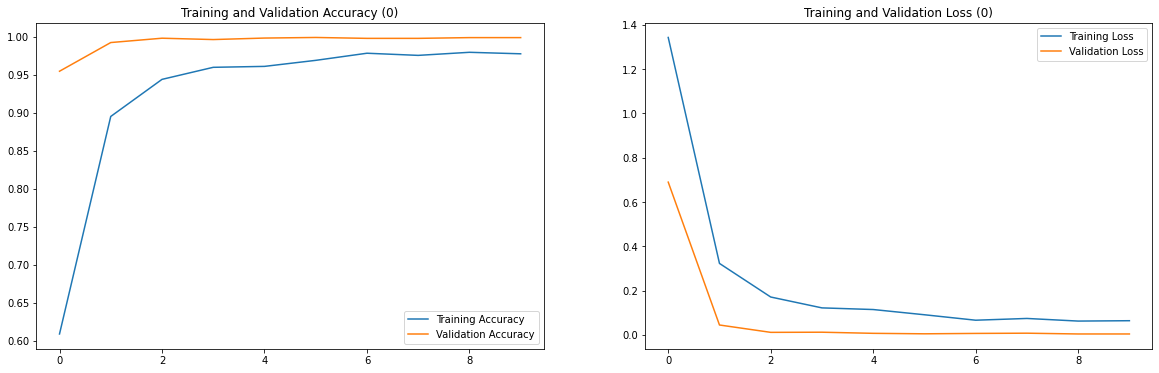

Training Time : 134.392 sec


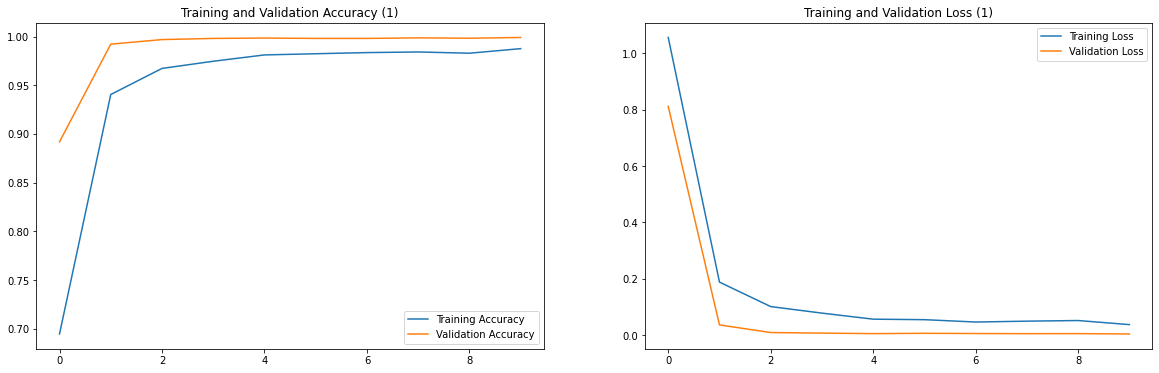

Training Time : 196.600 sec


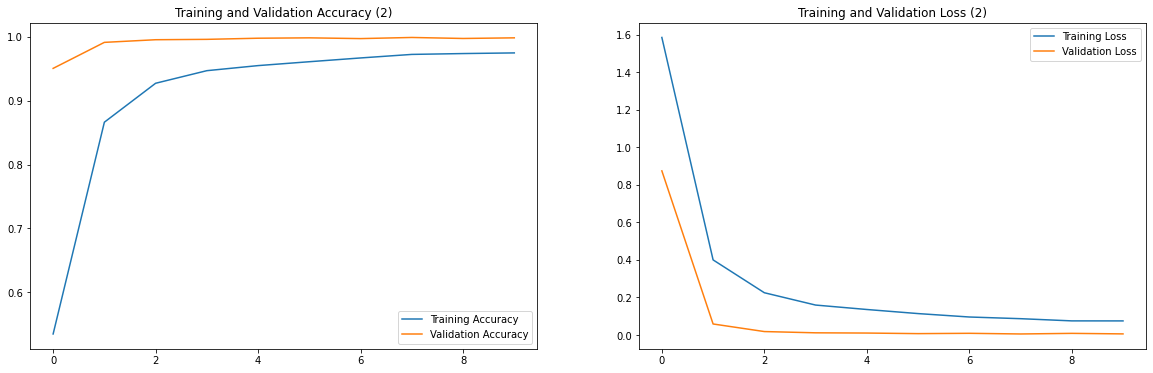

Training Time : 36.184 sec


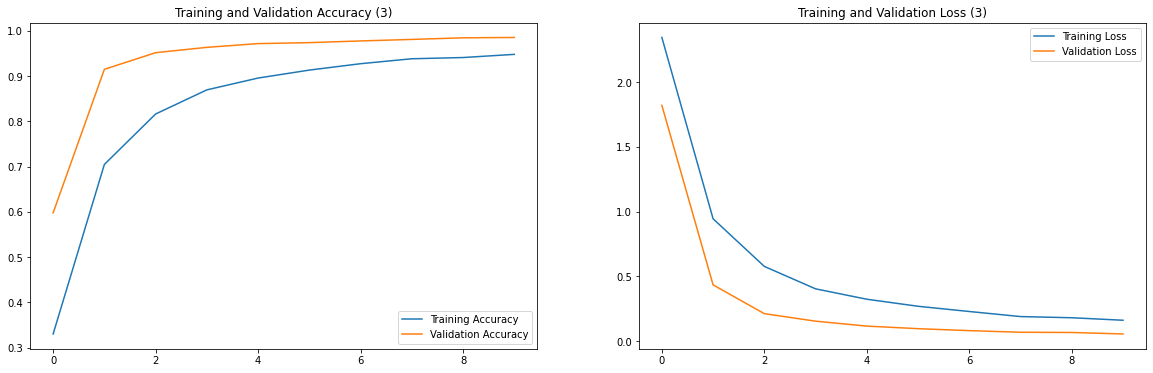

Training Time : 33.847 sec


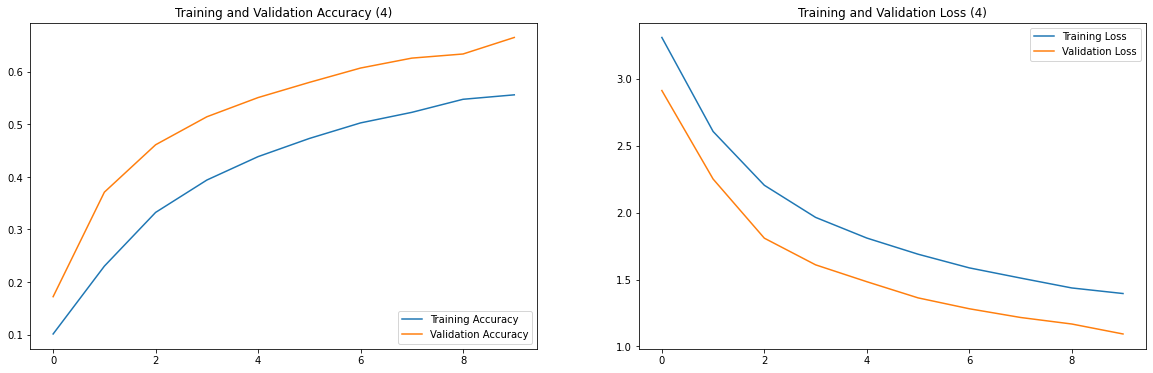

Training Time : 34.146 sec


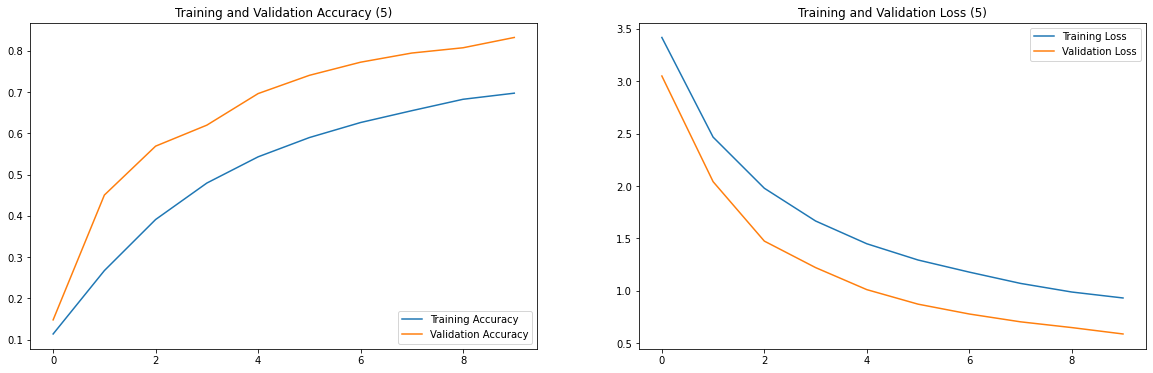

Training Time : 1418.892 sec


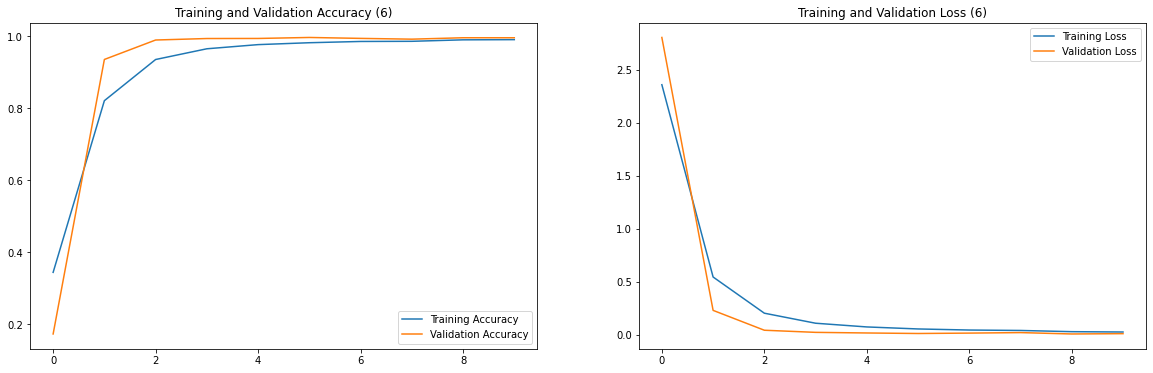

In [20]:
import tensorflow as tf
result_list = list()
for idx, result in enumerate(results):
  model, history, training_time, params = result[0], result[1], result[2], result[3]
  print(f'Training Time : {training_time:.3f} sec')
  # drawModel(idx, model)
  drawModelHistory(idx, history, training_time)
  result_list.append(resultvaluesTolist(model, history, training_time, params))


###save image with pandas

In [21]:
column_name = list(params.keys())+list(history.history.keys())+['model_layer_depth','training_time']+list(history.params.keys())
print(column_name, len(column_name))
import pandas as pd
result_df = pd.DataFrame(data=result_list, columns=column_name)
result_df_useful = result_df.loc[:,'filters':'training_time']
result_df_useful

['filters', '_padding', '_kernel_size', '_strides', '_pool_size', 'loss', 'accuracy', 'val_loss', 'val_accuracy', 'model_layer_depth', 'training_time', 'verbose', 'epochs', 'steps'] 14


,filters,_padding,_kernel_size,_strides,_pool_size,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time
0,16,same,"(3, 3)","(1, 1)","(2, 2)",0.063766,0.977526,0.003858,0.998820,8,169.956063
1,16,valid,"(3, 3)","(1, 1)","(2, 2)",0.037684,0.987538,0.004478,0.999017,8,134.391868
2,16,same,"(5, 5)","(1, 1)","(2, 2)",0.075013,0.974650,0.005840,0.998230,8,196.599931
3,16,same,"(3, 3)","(3, 3)","(2, 2)",0.160053,0.947915,0.053953,0.985254,8,36.184259
4,16,same,"(3, 3)","(3, 3)","(4, 4)",1.395277,0.556319,1.092955,0.665552,8,33.847255
5,16,valid,"(5, 5)","(3, 3)","(4, 4)",0.932845,0.697236,0.589580,0.832285,8,34.145900
6,128,same,"(3, 3)","(1, 1)","(2, 2)",0.027505,0.991000,0.012101,0.996264,20,1418.891932


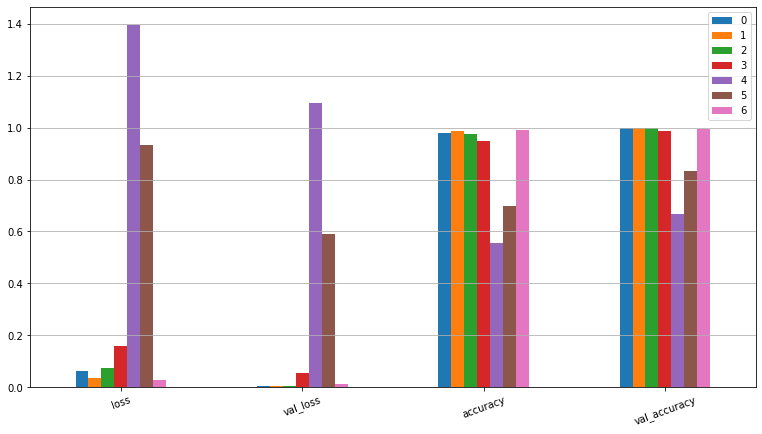

In [22]:
result_df_pick = result_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].T
plt.rcParams["figure.figsize"] = (13, 7)
result_df_pick.plot.bar()
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.show()

In [23]:
columns_mask = result_df.columns.map(lambda x: True if (x not in ('_kernel_size','_strides','_pool_size','verbose','epochs','steps')) else False )
columns_mask

Index([ True,  True, False, False, False,  True,  True,  True,  True,  True,
        True, False, False, False],
      dtype='object')

In [24]:
result_compare_df = result_df.loc[(0,1,6),columns_mask]
result_compare_df

,filters,_padding,loss,accuracy,val_loss,val_accuracy,model_layer_depth,training_time
0,16,same,0.063766,0.977526,0.003858,0.998820,8,169.956063
1,16,valid,0.037684,0.987538,0.004478,0.999017,8,134.391868
6,128,same,0.027505,0.991000,0.012101,0.996264,20,1418.891932
